# isogonal_hessian

> Study projection of cell-shape elasticity onto space of isogonal modes

In [ ]:
#| default_exp hessian

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.disorder as dso

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage, sparse

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import jit
import jax
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| export

from collections import defaultdict

In [ ]:
#| notest

import importlib

In [ ]:
importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Add methods to the HalfEdgeMesh class to compute isogonal modes

In [ ]:
#| export

@patch
def get_isogonal(self: msh.Vertex) -> Dict[int, NDArray[Shape["2"], Float]]:
    """
    Get isogonal mode for a given cell.
    
    Returns a dict: {faceid: translation vector} of primal vertices. Entries are
    
    j: T_j,bc / S_{self}bc
    
    where self,b,c are the three cells meeting at vertex j, and S is the area of the tension triangle.
    T_j is pointing towards vertex j (i.e. inwards)
    
    """

    # iterate over faces (cell vertices) adjacent to self. note: these are ccwise ordered by construction.
    isogonal_dict = {}
    for fc in self.faces:
        if fc is not None:
            S = fc.get_area()
            he = next(he for he in fc.hes if not self in he.vertices)            
            # note: hes are oriented ccwise
            T = dln.rot_mat(-np.pi/2)@(he.vertices[1].coords - he.vertices[0].coords)
            isogonal_dict[fc._fid] = T/S
        
    return isogonal_dict

In [ ]:
dln.rot_mat(np.pi/2) @ np.array([1,0])  # clockwise

array([ 6.123234e-17, -1.000000e+00])

In [ ]:
# testing this

mesh = dln.get_tri_hemesh()
mesh.set_voronoi()

v = mesh.vertices[30]
nghbs = v.faces
v, nghbs[0]

(Vertex(vid=30, coords=[0.5 0.9], incident hes=[138, 141, 155, 145, 148, 152]),
 Face(fid=46, primal_coords=[0.0, 0.6], hes=[138, 139, 140]))

<matplotlib.collections.PathCollection>

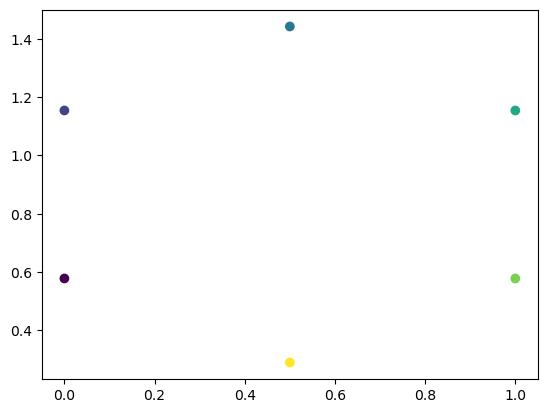

In [ ]:
# checking orientation conventions

#face = np.array([he.vertices[0].coords for he in nghbs[0].hes])
#plt.scatter(*face.T, c=np.arange(face.shape[0]))

cell = np.array([fc.primal_coords for fc in nghbs])
plt.scatter(*cell.T, c=np.arange(cell.shape[0]))

In [ ]:
iso_dict = v.get_isogonal()
iso_dict

{46: array([-2.        , -1.15470054]),
 47: array([-2.        ,  1.15470054]),
 51: array([1.41410032e-16, 2.30940108e+00]),
 50: array([2.        , 1.15470054]),
 49: array([ 2.        , -1.15470054]),
 48: array([-1.41410032e-16, -2.30940108e+00])}

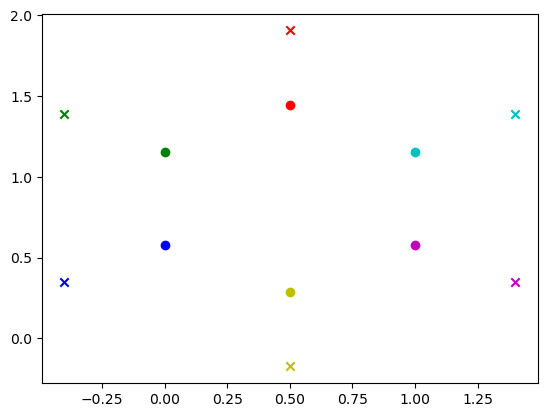

In [ ]:
# isogonal dilation of single cell

colors = list(mpl.colors.BASE_COLORS.values())
for c, fc in zip(colors, nghbs):
    plt.scatter(*fc.primal_coords, color=c)
    plt.scatter(*(fc.primal_coords+.2*iso_dict[fc._fid]), color=c, marker='x')


In [ ]:
mesh = msh.get_test_hemesh_large()
mesh.set_voronoi()
print(len(mesh.vertices))

%time iso_dicts = {key: val.get_isogonal() for key, val in mesh.vertices.items()}

# not super fast, but ok.

1250
CPU times: user 345 ms, sys: 1.85 ms, total: 347 ms
Wall time: 342 ms


In [ ]:
#| export

@patch
def get_isogonal_transform_matrix(self: msh.HalfEdgeMesh, flattened=False) -> NDArray[Shape["*,*,2"], Float]:
    """
    Create a matrix that transforms isogonal modes to vertex displacement
    
    To do the basis conversion, order vertices (cells) and faces (cell vertices) according to their indices.
    
    If flattened, flatten by combining face & x/y-component index
    
    """    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.vertices.keys()))}
    
    iso_matrix = np.zeros((len(self.vertices), len(self.faces), 2))
    iso_dicts = {key: val.get_isogonal() for key, val in self.vertices.items()}
    
    for vkey, iso_dict in iso_dicts.items():
        for fkey, dr in iso_dict.items():
            iso_matrix[vertex_key_dict[vkey], face_key_dict[fkey], :] = dr
    if flattened:
        return iso_matrix.reshape((iso_matrix.shape[0], iso_matrix.shape[1]*iso_matrix.shape[2]))
    return iso_matrix

In [ ]:
## testing

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()

iso_matrix = mesh.get_isogonal_transform_matrix()

iso_matrix.shape

(47, 70, 2)

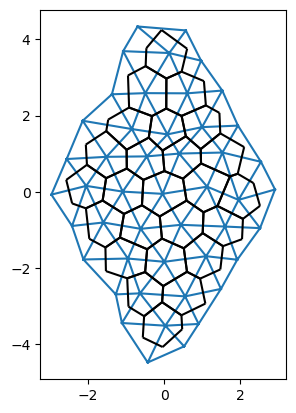

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
## test that isogonal modes don't affect the angle penalty

print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = np.einsum('i,ijk', theta, iso_matrix)
x0 = mesh.primal_vertices_to_vector(flattened=False)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=False)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr, axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 8.276712648580524e-16
mean translation 0.20758328369761322
post 3.793770853022216e-15


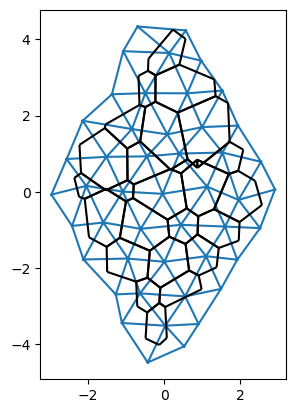

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
sorted(list(mesh.get_primal_edge_lens(oriented=True).values()))[:3] # some edge collapses = negative lengths

[-0.20976576967479885, -0.03802586461868229, -0.017968329877702735]

In [ ]:
#| export

def deflatten(x):
    return x.reshape((int(x.shape[0]/2),2))

In [ ]:
## check same thing but for "flattened" version to check everything works

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=True)


print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = theta @ iso_matrix
x0 = mesh.primal_vertices_to_vector(flattened=True)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=True)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(deflatten(dr), axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 6.250555628639626e-16
mean translation 0.1955358875469758
post 8.473222123939162e-15


In [ ]:
# comparing this to a random translation

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()
x0 = mesh.primal_vertices_to_vector(flattened=False)

dr_random = np.random.normal(size=(len(mesh.faces), 2), scale=.1)

new_positions = mesh.vector_to_primal_vertices(x0 + dr_random, flattened=False)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr_random, axis=1).mean())

print('post random', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

mean translation 0.1314988893095166
post random 0.5529270542144731


## Infer isogonal modes globally by comparing to Voronoi reference state and solving linear eqs.

In [ ]:
## test case: reference voronoi, plus isogonally transformed

mesh_ref = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh_ref.set_voronoi()

iso_matrix = mesh_ref.get_isogonal_transform_matrix(flattened=True)
theta = np.random.normal(scale=.1, size=len(mesh_ref.vertices))
theta -= theta.mean() # mean theta has no effect so normalize away

mesh_new = deepcopy(mesh_ref)
x0 = mesh_new.primal_vertices_to_vector(flattened=True)
new_positions = mesh.vector_to_primal_vertices(x0 + theta@iso_matrix, flattened=True)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]

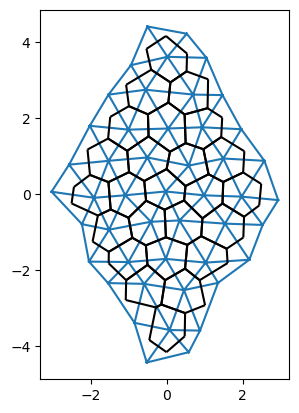

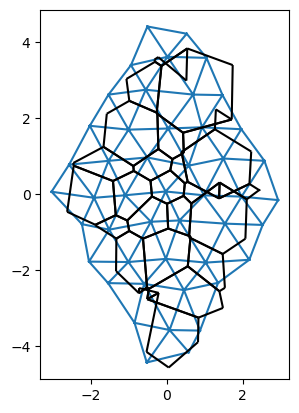

In [ ]:
mesh_ref.triplot(); mesh_ref.cellplot(); plt.gca().set_aspect('equal')
plt.show()

mesh_new.triplot(); mesh_new.cellplot(); plt.gca().set_aspect('equal')
plt.show()

Now infer the isogonal transform by solving for theta using least squares:
    
$$ \mathbf{x} =  \mathbf{x}_\text{Voronoi} + \text{Iso}^T \cdot \theta$$

where $\text{Iso}$ is the isogonal matrix of shape $(n_\text{cells}, n_\text{vertices})$

In [ ]:
x_new = mesh_new.primal_vertices_to_vector()
x_ref = mesh_ref.primal_vertices_to_vector()

theta_lstsq, _, _,  _ = np.linalg.lstsq(iso_matrix.T, x_new-x_ref, rcond=None)
theta_lstsq -= theta_lstsq.mean()

In [ ]:
mesh_infered = deepcopy(mesh_ref)
x0 = mesh_infered.primal_vertices_to_vector(flattened=True)
new_positions = mesh_infered.vector_to_primal_vertices(x0 + theta_lstsq@iso_matrix, flattened=True)
for key, val in mesh_infered.faces.items():
    val.primal_coords = new_positions[key]

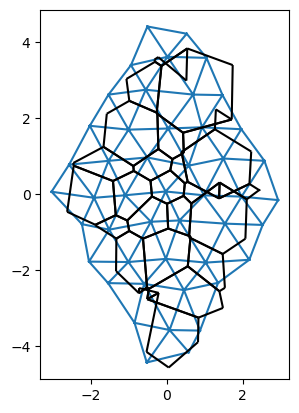

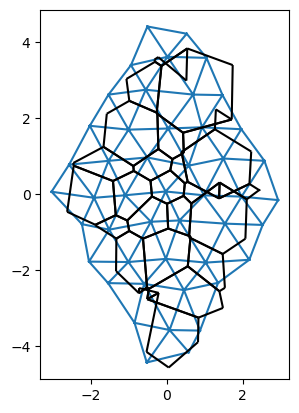

In [ ]:
mesh_infered.triplot(); mesh_infered.cellplot(); plt.gca().set_aspect('equal')
plt.show()

mesh_new.triplot(); mesh_new.cellplot(); plt.gca().set_aspect('equal')
plt.show()

In [ ]:
#| export

def get_isogonal_trafo(mesh: msh.HalfEdgeMesh, mesh_ref=None) -> Dict[int, float]:
    """
    Get isogonal trafo from mesh_ref->mesh, or, if mesh_ref is None, from isogonal reference to mesh.
    
    By convention, the sum of all isogonal modes is set to 0. Results are returned as a dict {vertex: theta}.
    """
    if mesh_ref is None:
        mesh_ref = deepcopy(mesh_ref)
        mesh_ref.set_voronoi()
    
    x = mesh.primal_vertices_to_vector()
    x_ref = mesh_ref.primal_vertices_to_vector()

    theta_lstsq = np.linalg.lstsq(iso_matrix.T, x-x_ref, rcond=None)[0]
    theta_lstsq -= theta_lstsq.mean()

    return mesh.vector_to_vertices(theta_lstsq)
    

## Getting the JAX hessian in the isogonal subspace

In [ ]:
#| export

get_E_hessian = jit(jax.hessian(iso.get_E))

## Testing 

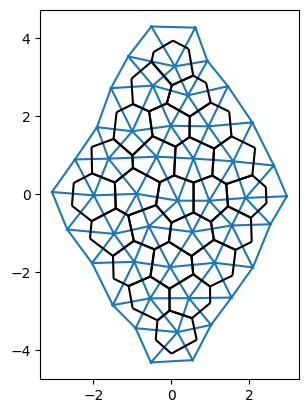

In [ ]:
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.1))
iso_matrix = mesh.get_isogonal_transform_matrix()

mesh.set_voronoi()

mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
x0 = mesh.primal_vertices_to_vector()
serialized_dict, _ = mesh.serialize_primal()

iso.get_E(x0, **serialized_dict, mod_area=1, angle_penalty=0)

Array(0.00442702, dtype=float64)

In [ ]:
# check 
areas = np.array([x for x in mesh.get_areas().values() if x is not None])
np.mean((areas -np.sqrt(3)/2)**2)

0.004427023686279263

In [ ]:
# now compute the hessian

hess = get_E_hessian(x0, **serialized_dict, mod_area=1, angle_penalty=0)

hess.shape, iso_matrix.shape

((140, 140), (47, 70, 2))

In [ ]:
# a,b,c =  cells. i,j,k = spatial components (x/y). f,g,h = faces

iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)

projected_hess = iso_matrix_flat @ hess @ iso_matrix_flat.T

projected_hess.shape

(47, 47)

<matplotlib.colorbar.Colorbar>

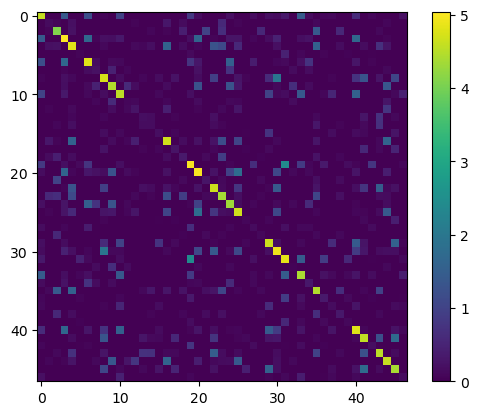

In [ ]:
n = projected_hess.shape[0]
perm_matrix = np.eye(n)[np.random.permutation(n)]

plt.imshow(np.abs(perm_matrix@(projected_hess@perm_matrix.T) ))
plt.colorbar()

## Toy problem

In [ ]:
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0, nx=15, ny=15))  #(7,13)  -(15, 19), (9,9)
mesh_orig = deepcopy(mesh)

mesh.transform_vertices(lambda x: np.array([x[0], x[1] +0.1*np.sign(x[1])*x[1]**2]))
mesh.transform_vertices(dln.shear_mat(1.5))

mesh.set_voronoi()

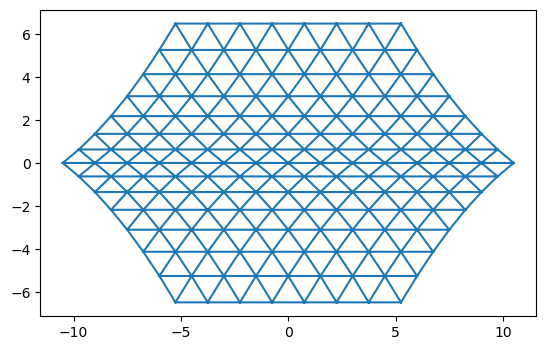

In [ ]:
mesh.triplot()

#mesh.cellplot()
plt.gca().set_aspect('equal')

## Diagonlization, direct & dense

Compute the Hessian -> multiply with matrices to project onto isogonal modes -> diagonalize

Do all of it using direct diag & dense matrices. Later, for large systems, it might be appropriate to use indirect computation of the Jacobian/vector product, sparse matrices to represent the isogonal modes, and iterative diagonalization (e.g. Lanzos).

In [ ]:
## triangular lattice with voronoi

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.15, nx=17, ny=15))  #(7,13)  -(15, 19), (9,9)

#mesh.transform_vertices(lambda x: np.array([x[0], x[1] +0.1*np.sign(x[1])*x[1]**2]))

mesh.transform_vertices(dln.shear_mat(1.05))
mesh.set_voronoi()


In [ ]:
len(mesh.vertices)

199

In [ ]:
# disordered
mesh = dso.create_poisson_disk_initial(n_vertices=202, initial_strain=0.05, random_seed=1)[0]
mesh.set_voronoi()


AttributeError: 'HalfEdgeMesh' object has no attribute 'remove_obtuse_bdry'

In [ ]:
len(mesh.vertices)

In [ ]:
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=False)
iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)
serialized_dict, _ = mesh.serialize_primal()


for v in mesh.vertices.values():
    v.rest_shape = np.sqrt(3)*np.eye(2)

In [ ]:
mod_shear = 1

energy_args={'mod_area': 0, 'mod_perimeter': 0,
             'mod_bulk': 1, 'mod_shear': mod_shear,
             'angle_penalty': 1000}

sol = mesh.optimize_cell_shape(energy_args=energy_args, tol=1e-5, maxiter=100000, return_sol=True)

minimal_l = .01
flipped, failed_flip = mesh.intercalate(exclude=[], minimal_l=minimal_l, reoptimize=True,
                                        optimizer_args={"energy_args": energy_args})
print(flipped)
sol['fun']

[]


0.12386930700420738

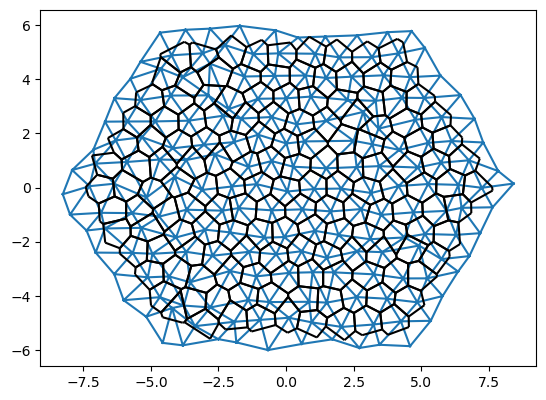

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
%%time

x0 = mesh.primal_vertices_to_vector()

hess = get_E_hessian(x0, **serialized_dict,
                     mod_bulk=1, mod_shear=mod_shear,
                     mod_area=0, mod_perimeter=0)
projected = iso_matrix_flat @ hess @ iso_matrix_flat.T
vals, vecs = np.linalg.eigh(projected)

CPU times: user 1.83 s, sys: 264 ms, total: 2.1 s
Wall time: 1.68 s


<matplotlib.colorbar.Colorbar>

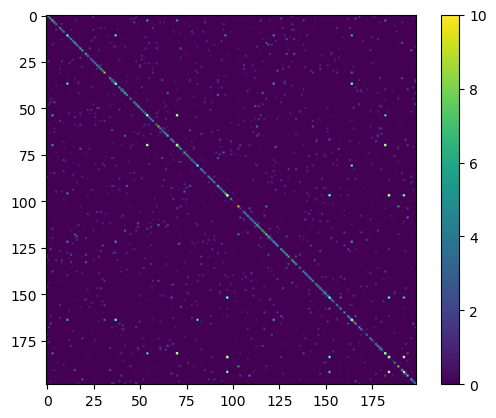

In [ ]:
n = projected.shape[0]
perm_matrix = np.eye(n)[np.random.permutation(n)]

plt.imshow(np.abs(perm_matrix@(projected@perm_matrix.T)), vmax=10)
plt.colorbar()

In [ ]:
E = iso.get_E(x0, **serialized_dict, mod_bulk=1, mod_shear=mod_shear, mod_area=0, mod_perimeter=0 ,angle_penalty=0)

E # .14 if not optimized. so we are certainly not at a minimum!

Array(3.2496281, dtype=float64)

In [ ]:
# hessian eigenvalues vs shear modulu
# 0     : 0.01 1e-3
# 0.125 : 0.38 1e-3
# 0.25  : 0.7 1e-3
# 0.5   : 1.4 1e-3
# 1     : 2.8 1e-3

In [ ]:
vals.shape, vals[:6]

((199,),
 array([2.90031055e-15, 4.69555510e-15, 3.46263532e-14, 1.66611879e-03,
        1.72311568e-03, 6.65158312e-03]))

[<matplotlib.lines.Line2D>]

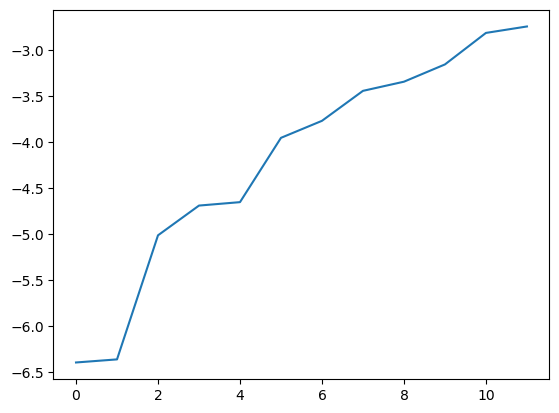

In [ ]:
plt.plot(np.log(vals[3:15]))

<matplotlib.collections.PathCollection>

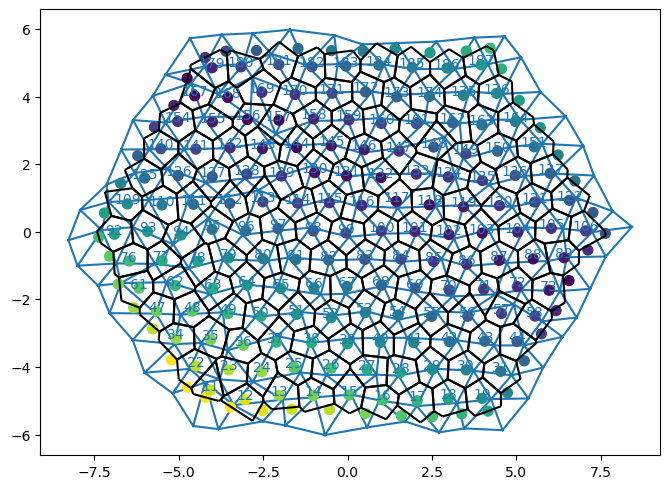

In [ ]:
## spatial plot of magnitudes

n_eigen = 2

fig = plt.figure(figsize=(8,8))

plt.gca().set_aspect("equal", adjustable="box")
mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

# now calculate the energies and centroids

iso_mode = mesh.vector_to_vertices(np.abs(vecs[:, n_eigen]), flattened=False)

for_scttr = np.stack([np.hstack([mesh.vertices[key].get_centroid(), [val]])
                      for key, val in iso_mode.items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.15, s=50)

# 0 = linear gradient i.e. translation. 3 = quadratic i.e. shear

In [ ]:
# need to re-normalize the eigenvectors /isogonal transform matrix, so they result in uniform displacement !

## Apply a trafo based on the lowest eigenvec and see whether energy changes

In [ ]:
vals[20], vals.shape

(0.13190891615047437, (199,))

In [ ]:
mesh_new = deepcopy(mesh)

n_eigen = 3 # 5,6 are the shears mow in disodered case. below, translation + edge
magnitude = 11 # 10.5

theta = magnitude * vecs[:, n_eigen] # 0, 1, 2 = translation. 3, 4 = shear. then come a bunch localized at the bdry,
dr = theta @ iso_matrix_flat
x0 = mesh_new.primal_vertices_to_vector()

new_positions = mesh_new.vector_to_primal_vertices(x0 + dr)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]

    
# mode 3: 8 @ 0.3, mode 4: 4 @ 0.3. say 6.

In [ ]:
1e3*vals[3:7]

array([1.573, 1.706, 6.1  , 8.9  ])

In [ ]:
np.linalg.norm(deflatten(dr)-deflatten(dr).mean(axis=0), axis=1).mean() # .035 -> .039

# triangular: 0.6

0.6144745563870744

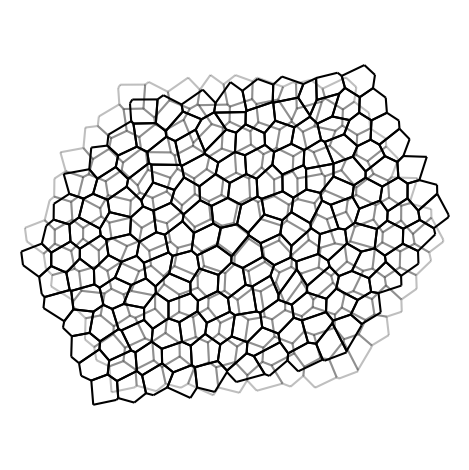

In [ ]:
mesh.cellplot(alpha=.25)
mesh_new.cellplot()
#mesh_new.triplot()
#mesh_new.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

lim = 8
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")

plt.tight_layout()
#plt.savefig("plots/SI figs and movies/isogonal_hessian_shear_mode_2.pdf")

# mode 30 - lowest non-edge mode - is a radial shear.

# multipole shear expansion?

# for shape energy, it looks more like localization at pairs of cells. 

In [ ]:
x0_pre = mesh.primal_vertices_to_vector()
x0_post = mesh_new.primal_vertices_to_vector()

serialized_dict, _ = mesh_new.serialize_primal()


print('pre iso', iso.get_E(x0_pre, **serialized_dict, mod_bulk=1, mod_shear=1, mod_area=0, mod_perimeter=0,
                           angle_penalty=0))
print('post iso', iso.get_E(x0_post, **serialized_dict, mod_bulk=1, mod_shear=1, mod_area=0, mod_perimeter=0,
                            angle_penalty=0))

# .03 -> .06 for lowest mode
# .03 -> .12 for highest mode

# looks like the isogonal modes work roughly as expected.
# the null modes increase energy less than the highest modes.

# presumably we should evaluate this around the minimum.

# as expected, lowest eigenvector is a translation!

pre iso 0.13211131444874308
post iso 0.2235885846099249


In [ ]:
# 0.6 Delanunay no angle penalty: 
# pre iso 0.1796216279019345
# post iso 0.19145048885219113

# 0.6 ordered no angle penalty:
# pre iso 0.13211131444874308
# post iso 0.2235885846099249

In [ ]:
# shearing random Delaunay:
# pre iso 0.2157160472749474
# post iso 12.1

# for 0.3 displacement: 4.17

# shearing triangular lattice:
# pre iso 0.14290057460782385
# post iso 0.24658486430253557

# for 0.3 displacement: 0.17

# shear set to have equivalent average vertex displacment.

## measure shear modulus

Plot displacement vs energy

In [ ]:
n_eigen = 3


displacement = []
energy = []
magnitudes = np.linspace(-5.2, 8, 50)
shear = []

x0_pre = mesh.primal_vertices_to_vector()

keys = sorted(mesh.vertices.keys())
centroids_pre = np.stack([mesh.vertices[k].get_centroid() for k in keys])

for magnitude in tqdm(magnitudes):

    mesh_new = deepcopy(mesh)

    theta = magnitude * vecs[:, n_eigen]
    dr = theta @ iso_matrix_flat
    x0 = mesh_new.primal_vertices_to_vector()

    new_positions = mesh_new.vector_to_primal_vertices(x0 + dr)
    for key, val in mesh_new.faces.items():
        val.primal_coords = new_positions[key]

    x0_post = mesh_new.primal_vertices_to_vector()
    serialized_dict, _ = mesh_new.serialize_primal()

    displacement.append(np.sign(magnitude) * np.linalg.norm(deflatten(dr), axis=1).mean())
    energy.append(iso.get_E(x0_post, **serialized_dict, mod_bulk=1, mod_shear=mod_shear,
                            mod_area=0, mod_perimeter=0, angle_penalty=0)) # 1000

    centroids_post = np.stack([mesh_new.vertices[k].get_centroid() for k in keys])
    matrix = np.linalg.lstsq(centroids_pre, centroids_post, rcond=None)[0]
    vals = np.linalg.eigvals(matrix)
    shear.append(vals[0] / vals[1]-1)
    
energy = np.array(energy)
energy -= energy.min()
shear = np.array(shear)

mean_length = np.mean(list(mesh.get_edge_lens().values()))
displacement = np.array(displacement) / mean_length

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
shear.min(), shear.max()

(-0.11686805271288614, 0.21013403941648123)

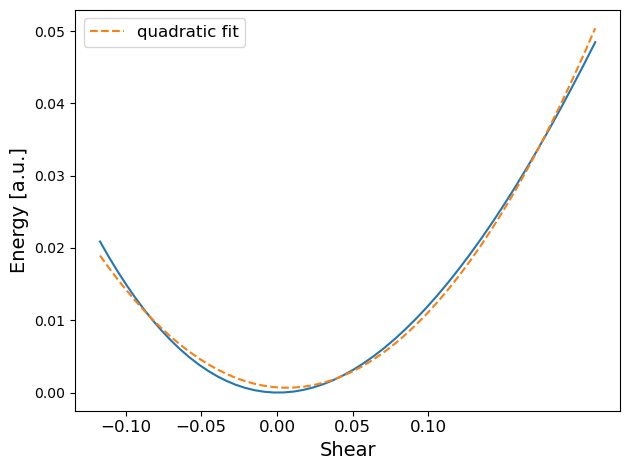

In [ ]:
plt.plot(shear, energy)

poly = np.polyfit(shear, energy, deg=2,)
plt.plot(shear, np.polyval(poly, shear), ls='--', label='quadratic fit')
plt.legend(fontsize=12)

plt.xticks([-.1, -.05, 0, .05, .1], fontsize=12)
plt.xlabel("Shear", fontsize=14)
plt.ylabel("Energy [a.u.]", fontsize=14)
plt.tight_layout()

#plt.savefig("plots/SI figs and movies/shear_vs_energy_mod_0.5.pdf")

In [ ]:
poly[0]/2 # .7 for ordered lattice, .02 for disordered. (angle penalty = 0)

0.6002466655752362

ordered:

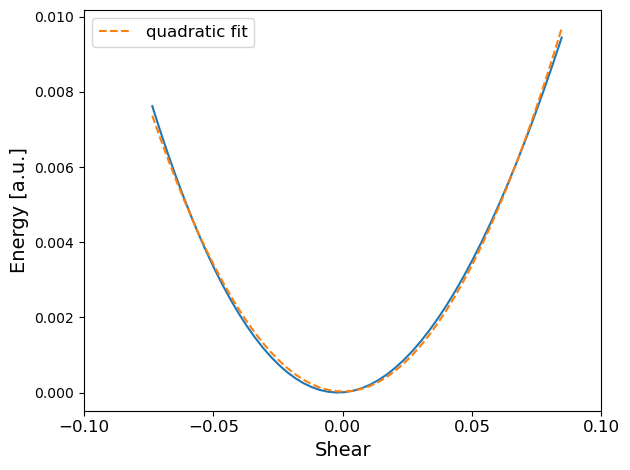

disordered:

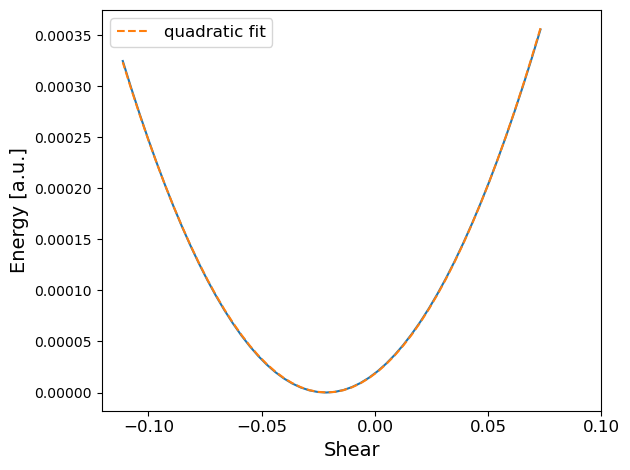

In [ ]:
shear_vs_curvature = [[1, .72],
                      [.5, .37],
                      [.25, .19],
                      [.125, .1],
                      [0, 0]]

shear_vs_curvature = np.array(shear_vs_curvature)

Text(0, 0.5, 'tissue shear modulus\n(curvature of energy/shear curve)')

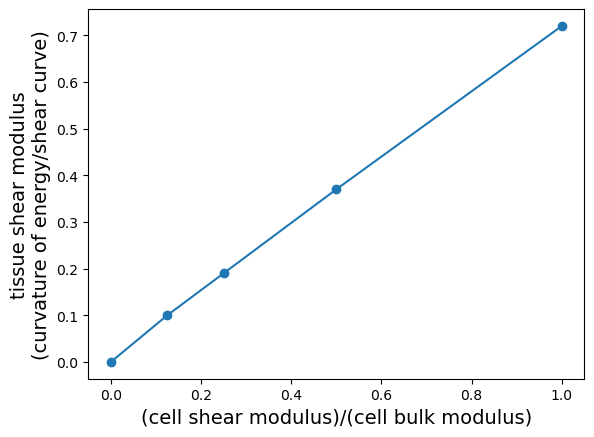

In [ ]:
plt.plot(*shear_vs_curvature.T, marker="o")
plt.xlabel("(cell shear modulus)/(cell bulk modulus)", fontsize=14)
plt.ylabel("tissue shear modulus\n(curvature of energy/shear curve)", fontsize=14)
#plt.savefig("plots/SI figs and movies/tissue_shear_vs_cell_shear.pdf")

### Isogonal metric elasticity

Attempt alternative formulation of the elastic energy minimization. Direct minimization in terms of isogonal modes.

1. Use normal elastic energy, just in terms of isogonal potential
2. Use metric elasticity formulation based on Voronoi metric + 2nd derivatives of isogonal Hessian.

In [ ]:
#importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
from jax.experimental import sparse as jsparse

In [ ]:
# initialize mesh
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.15, nx=15, ny=15))  #(7,13)  -(15, 19), (9,9)
#mesh.transform_vertices(dln.shear_mat(1.05))
for v in mesh.vertices.values():
    v.rest_shape = np.sqrt(3)*np.eye(2)
mesh.set_voronoi()

# compute isogonal jacobian and Voronoi reference positions
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=False)
iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)
voronoi = mesh.primal_vertices_to_vector(mesh.get_voronoi())

# serialize mesh
serialized_dict, _ = mesh.serialize_primal()
# set energy parameters
energy_args={'mod_area': 0, 'mod_perimeter': 0,
             'mod_bulk': 1, 'mod_shear': 1,
             'angle_penalty': 1000}

# compute energy directly
print('energy', iso.get_E(voronoi, **(serialized_dict | energy_args)))

# define energy as a function of isogonal potentials
def get_E_Theta_temp(Theta):
    return iso.get_E(voronoi+jnp.dot(Theta, iso_matrix_flat),
                     **(serialized_dict | energy_args))

print('energy isogonal', get_E_Theta_temp(jnp.ones(len(mesh.vertices))))

energy 19.23836206217947
energy isogonal 19.238362062179466


In [ ]:
%%time
x0 = mesh.primal_vertices_to_vector()
args = iso.kwargs_to_args(iso.get_E, mesh.serialize_primal()[0] | energy_args)

sol = optimize.minimize(iso.get_E, x0, jac=iso.get_E_jac, args=args,
                        method="CG", tol=1e-4, options={"maxiter": 1e4})
sol['fun']

CPU times: user 1.55 s, sys: 970 µs, total: 1.55 s
Wall time: 1.55 s


0.12638618795497006

In [ ]:
#| export

@jit
def get_E_Theta(Theta0, e_lst_primal, e_dual, cell_list, bdry_list, valence_mask, iso_matrix, voronoi,
                mod_bulk=0, mod_shear=0, rest_shape=np.sqrt(3)*np.eye(2),
                mod_area=0, A0=np.sqrt(3)/2, mod_perimeter=0, P0=2*np.sqrt(3),
                angle_penalty=1000, bdry_penalty=1000, epsilon_l=(1e-3, 1e-3)):
    """Copy of iso.get_E, using isogonal parameters instead"""
    return iso.get_E(voronoi+Theta0 @ iso_matrix,
                     e_lst_primal, e_dual, cell_list, bdry_list, valence_mask,
                     mod_bulk=mod_bulk, mod_shear=mod_shear, rest_shape=rest_shape,
                     mod_area=mod_area, A0=A0, mod_perimeter=mod_perimeter, P0=P0,
                     angle_penalty=angle_penalty, bdry_penalty=bdry_penalty, epsilon_l=epsilon_l)
        
get_E_Theta_jac = jit(jax.grad(get_E_Theta))

In [ ]:
%%time
Theta0 = jnp.ones(len(mesh.vertices))

extra_args = {"voronoi": mesh.primal_vertices_to_vector(mesh.get_voronoi()),
              "iso_matrix": jsparse.BCOO.fromdense(mesh.get_isogonal_transform_matrix(flattened=True))}

args = iso.kwargs_to_args(get_E_Theta, mesh.serialize_primal()[0] | extra_args | energy_args)

sol = optimize.minimize(get_E_Theta, Theta0, jac=get_E_Theta_jac, args=args,
                        method="CG", tol=1e-4, options={"maxiter": 1e4})
sol['fun']

# this works! faster than usual, too. But does it work for a larger mesh? Not necessarily.
# lack of appropriate sparse matrix implementation ...

CPU times: user 334 ms, sys: 2.48 ms, total: 337 ms
Wall time: 331 ms


0.12847479160548272

## next, use proxy-energy based on the Voronoi metric and the isogonal strain

In [ ]:
def get_cell_metric(poly: NDArray[Shape["*,2,..."],Float], epsilon_l=1e-4) -> NDArray[Shape["2,2,..."],Float]:
    """
    Compute cell metric tensor from polygon vertex coords.
    
    Assumes that the vertex coords are order clock- or counter-clockwise.
    Computes Sum_e l_e \outer l_e where l_e is the vector along
    polygon e.
    
    Parameters
    ----------
    poly : (n_vertices, 2, n_samples) array
        Input polygon(s)
    epsilon_l : float
        Regularization to keep function diff'ble for 0-edge length polygons
        
    Returns
    -------
    (2, 2, n_samples) array
        Shape tensor
    """

    edges = poly - jnp.roll(poly, 1, axis=0)
    return jnp.einsum('ei...,ej...->ij...', edges, edges)

In [ ]:
def vectors_angle(a: NDArray[Shape["*"],Float], b: NDArray[Shape["*"],Float]) -> float:
    """Angle between two vectors"""
    inner = (a@b)/np.sqrt((a@a)*(b@b))
    return np.arccos(np.clip(inner, -1, 1))

In [ ]:
#| export

@patch
def get_voronoi_metric(self: msh.Vertex):
    if not self.is_bdry():
        Ts = np.stack([he.vertices[0].coords-self.coords for he in self.incident])
        metric = 2 * np.einsum('ai,aj->ij', Ts, Ts) / Ts.shape[0]
    else:
        metric = np.eye(2) # in principle, need something better, e.g. mirroring across the boundary
    return metric

In [ ]:
@jit
def get_hessian(points, values):
    """Compute Hessian by approximating function with quadratic polynomial"""
    poly_feats = jnp.stack([jnp.ones_like(values), coords[0], coords[1], coords[0]**2, coords[1]**2,
                            coords[0]*coords[1]]).T
    params = jnp.linalg.lstsq(poly_feats, values, rcond=None)[0]
    return jnp.array([[2*params[3], params[5]], [params[5], 2*params[4]]])

v = mesh.vertices[10]

coords = (np.stack([v.coords] + [he.vertices[0].coords for he in v.incident]) - v.coords).T
theta = coords[0]*coords[1]
get_hessian(coords, theta)

Array([[-0.,  1.],
       [ 1., -0.]], dtype=float64)

In [ ]:
## what ingredients are necessary for the Voronoi energy computation?
# - g_Voronoi, fixed, for each cell (n_cell, 2, 2)
# - voronoi primal vertex positions  (n_vertex, 2)
# - list of all half-edges (as pairs of face indices) for each cell (n_cell, ~6, 2)
# - iso_matrix (n_cell, n_vertices, 2)
# - scaling factor eta

@patch
def serialize_voronoi(self: iso.CellHalfEdgeMesh):
    """
    Serialize mesh as required for Voronoi/Isogonal metric elasticity
    
    Parameters
    ----------
    self: iso.CellHalfEdgeMesh
    
    Returns
    -------
    dict containing the following entries:
        v_Voronoi: np.array of shape (n_vertex, 2)
            Voronoi vertex positions
        g_Voronoi: np.array of shape (n_cell, 2, 2)
            Cell shape tensor computed from Voronoi positions
        iso_matrix: np.array of shape (n_cell, 2, n_vertices)
            Matrix translation Isogonal modes -> vertex displacement
        cell_he_list: list of len n_cell
            List with one entry for each cell, giving the primal vertex ids of each edge
        scaling_factor: float
            Normalization factor for strain computation
        t_Voronoi: np.array of shape (n_cell, 2)
            Tension vertex positions
        cell_nghb_list: list of len n_cell
            For every cell, the Ids of its neighbors
    """
    # ughh
    mesh_voronoi = deepcopy(mesh)
    mesh_voronoi.set_voronoi()

    vertex_keys = sorted([key for key, val in mesh.vertices.items() if not val.is_bdry()])
    edge_keys = sorted(mesh.hes.keys())
    face_keys = sorted(mesh.faces.keys())

    vertex_key_dict, face_key_dict = [{x: ix for ix, x in enumerate(y)} for y in [vertex_keys, face_keys]]

    # most items are easy to compute
    v_Voronoi = np.array([mesh_voronoi.faces[key].primal_coords for key in face_keys])
    g_Voronoi = np.stack([get_cell_metric(self.vertices[key].primal_coords) for key in vertex_keys])
    iso_matrix = self.get_isogonal_transform_matrix(flattened=False).transpose((1,2,0))
    scaling_factor = np.mean(list(self.get_primal_edge_lens().values()))**2

    # excpet the cell list, which is a pain
    cell_he_list = [[face_key_dict[fc._fid] for fc in self.vertices[key].faces] for key in vertex_keys]
    cell_he_list = [np.stack([val, np.roll(val, 1)]).T for val in cell_he_list]
    
    # and more
    t_Voronoi = np.array([mesh_voronoi.vertices[key].coords for key in vertex_keys])
    cell_nghb_list = [[vertex_key_dict[he.vertices[0]._vid] for he in self.vertices[key].incident]
                      for key in vertex_keys]
    
    return {"v_Voronoi": v_Voronoi, "g_Voronoi": g_Voronoi, "iso_matrix": iso_matrix,
            "cell_he_list": cell_he_list, "scaling_factor": scaling_factor,
            "t_Voronoi": t_Voronoi, "cell_nghb_list": cell_nghb_list}

In [ ]:
# fomulating boundary conditions - real space to isogonal potentials??

In [ ]:
# using these ingredients, we ought to be able to compute the "metric elasticity", in jax style

@jit
def get_E_Voronoi_metric(Theta0, g0, v_Voronoi, g_Voronoi, iso_matrix, cell_he_list, scaling_factor):
    """
    Compute Voronoi metric elasticity energy
    """
    # compute the shift in coordinates due to Theta
    dr = iso_matrix @ Theta0
    energy = 0
    for inds, g_V in zip(cell_he_list, g_Voronoi):
        # compute voronoi strain tensor
        dr_cell = dr[inds[:,0],:]-dr[inds[:,1],:]
        cell_edges = v_Voronoi[inds[:,0],:]-v_Voronoi[inds[:,1],:]
        strain_iso = np.eye(2) + 2*jnp.mean(jnp.einsum('ai,aj->aij', cell_edges, dr_cell), axis=0)/scaling_factor
        
        #strain_iso = jnp.linalg.lstsq(cell_edges, cell_edges+dr_cell, rcond=None)[0]

        #r_cell = dr[inds[:,0],:]
        #cell_verts = v_Voronoi[inds[:,0],:]
        #strain_iso = np.eye(2) + 2*jnp.mean(jnp.einsum('ai,aj->aij', cell_edges, dr_cell), axis=0)/scaling_factor
        #strain_iso = jnp.linalg.lstsq(cell_verts, cell_verts+r_cell, rcond=None)[0]

        
        # compute the energy
        u = (strain_iso.T @ g_V @ strain_iso - g0) # 2*jnp.eye(2), jnp.eye(2)
        energy = energy + jnp.trace(u.T @ u)
        
    return energy

get_E_Voronoi_metric_jac = jit(jax.grad(get_E_Voronoi_metric))

In [ ]:
# initialize mesh
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.1, nx=7, ny=9))
mesh.transform_vertices(dln.shear_mat(1.1)) #1.15

#mesh = dso.create_poisson_disk_initial(n_vertices=100, initial_strain=0.1, random_seed=1)[0]
mesh.set_voronoi()

In [ ]:
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0, nx=11, ny=17))  #(7,13)  -(15, 19), (9,9)

mesh.transform_vertices(lambda x: np.array([x[0], x[1] +0.1*np.sign(x[1])*x[1]**2]))
mesh.transform_vertices(dln.shear_mat(1.3))

mesh.set_voronoi()

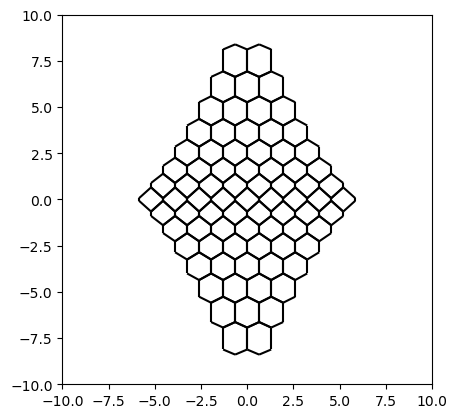

In [ ]:
mesh.cellplot(alpha=1)

lim = 10
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.gca().set_aspect("equal", adjustable="box")


In [ ]:
serialized = mesh.serialize_voronoi()
iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)

KeyError: 1

In [ ]:
serialized["g_Voronoi"].mean(axis=0)

array([[1.69 , 0.   ],
       [0.   , 1.642]])

In [ ]:
theta0 = np.ones(len(mesh.vertices))
#theta0 = np.random.normal(size=len(mesh.vertices), scale=.03)

g0 = jnp.diag(jnp.array([1, 1]))
serialized["g0"] = g0

print(get_E_Voronoi_metric(theta0, **serialized))
get_E_Voronoi_metric_jac(theta0, **serialized)

91.32624897532024


Array([-27.314, -54.627, -27.314,  -0.282,  66.774,  66.774,  -0.282,
        -2.84 ,  14.168,  -9.919,  14.168,  -2.84 ,  -4.593,  10.493,
        -7.318,  -7.318,  10.493,  -4.593,  -5.687,   8.104,  -5.018,
        -5.018,  -5.018,   8.104,  -5.687,  -6.32 ,   6.784,  -3.121,
        -3.121,  -3.121,  -3.121,   6.784,  -6.32 ,  -6.761,   6.369,
        -1.676,  -1.676,  -1.676,  -1.676,  -1.676,   6.369,  -6.761,
        -7.465,   7.409,  -0.343,  -0.343,  -0.343,  -0.343,  -0.343,
        -0.343,   7.409,  -7.465,  -7.885,   8.816,  -0.415,  -0.415,
        -0.415,  -0.415,  -0.415,  -0.415,  -0.415,   8.816,  -7.885,
        -7.465,   7.409,  -0.343,  -0.343,  -0.343,  -0.343,  -0.343,
        -0.343,   7.409,  -7.465,  -6.761,   6.369,  -1.676,  -1.676,
        -1.676,  -1.676,  -1.676,   6.369,  -6.761,  -6.32 ,   6.784,
        -3.121,  -3.121,  -3.121,  -3.121,   6.784,  -6.32 ,  -5.687,
         8.104,  -5.018,  -5.018,  -5.018,   8.104,  -5.687,  -4.593,
        10.493,  -7.

In [ ]:
# now attempt to optimize this

theta0 = jnp.ones(len(mesh.vertices))

args = iso.kwargs_to_args(get_E_Voronoi_metric, serialized)
sol = optimize.minimize(get_E_Voronoi_metric, theta0, args=args, jac=get_E_Voronoi_metric_jac,
                        method="CG", tol=1e-4, options={"maxiter": 1e5})
sol['fun']

7.310615012752844e-07

In [ ]:
# comparison with standard method
mesh_conventional = deepcopy(mesh)
for v in mesh_conventional.vertices.values():
    v.rest_shape = np.sqrt(3)*np.sqrt(g0)
mesh_conventional.optimize_cell_shape(energy_args={'mod_shear': 1, "mod_bulk": 0},
                                      tol=1e-3, maxiter=1e4, bdr_weight=4)


In [ ]:
np.mean([get_cell_metric(v.primal_coords) for v in mesh_conventional.vertices.values() if not v.is_bdry()], axis=0)

array([[ 1.176, -0.   ],
       [-0.   ,  1.112]])

In [ ]:
# apply determined isogonal modes

theta_final = sol["x"]
dr = theta_final @ iso_matrix_flat
x0 = mesh.primal_vertices_to_vector()
new_positions = mesh.vector_to_primal_vertices(x0 + dr)

mesh_new = deepcopy(mesh)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]

In [ ]:
np.mean([get_cell_metric(v.primal_coords) for v in mesh_new.vertices.values() if not v.is_bdry()], axis=0)

array([[ 1.056, -0.   ],
       [-0.   ,  1.119]])

In [ ]:
#mesh.transform_primal_vertices(dln.scale_mat(0.95)) #0.825
#mesh_conventional.transform_primal_vertices(dln.scale_mat(1.05))

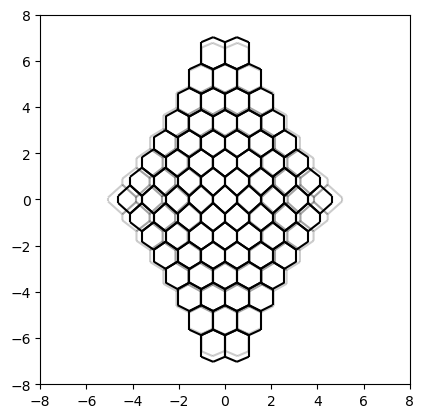

In [ ]:
#mesh.triplot()

#mesh.cellplot(edge_colors={he: "tab:blue" for he in mesh.hes.keys()}) # initial condition = Voronoi
mesh_conventional.cellplot(alpha=0.2) # result from stnadrad elastic energy minimization
mesh_new.cellplot(alpha=1) # Voronoi-metric base

lim = 8
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.gca().set_aspect("equal", adjustable="box")


# changing the reference shape works isotropically, and along the axis of tension anisotropy, but not orthogonal
# to it. Weird! Why?

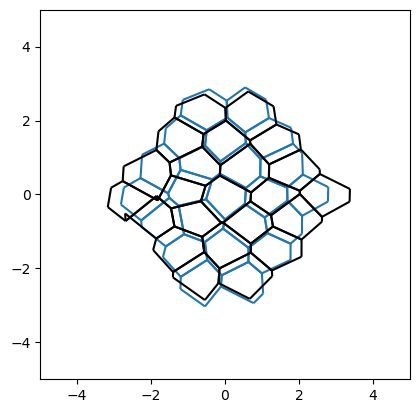

## Experimentation with shear computation

In [ ]:
# isogonal shear. copute isogonal shear for each edge, and project it onto the edge (already (anti) parallel)

theta0 = np.random.normal(size=len(mesh.vertices), scale=.03)
voronoi = mesh.primal_vertices_to_vector(mesh.get_voronoi())

dr = np.einsum('a,abc->bc', theta0, iso_matrix)
print(dr.shape)

# need (oriented) displacement vectors.
edge_keys = sorted(mesh.hes.keys())
vertex_keys = sorted(mesh.vertices.keys())
face_keys = sorted(mesh.faces.keys())

vertex_key_dict = {x: ix for ix, x in enumerate(vertex_keys)}
face_key_dict = {x: ix for ix, x in enumerate(face_keys)}

mesh.set_voronoi()
voronoi_2d = np.array([mesh.faces[key].primal_coords for key in face_keys])

hes = np.array([[vertex_key_dict[v._vid] for v in mesh.hes[e].vertices] for e in edge_keys])
print(hes.shape)

dr_ij = dr[hes[:,0],:]-dr[hes[:,1],:]

# actually, it would be best to get the displacement vectors of one cell all at once.
# need to know which hes belong to which cell (need he opposite of each )
cell_he_dict = {vertex_keys[v._vid]: [face_key_dict[fc._fid] for fc in v.faces]
                for v in mesh.vertices.values() if not v.is_bdry()}

cell_he_dict = {key: np.stack([val, np.roll(val, 1)]).T for key, val in cell_he_dict.items()}


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (43,)->(43) (47,70,2)->(70,2,47) 

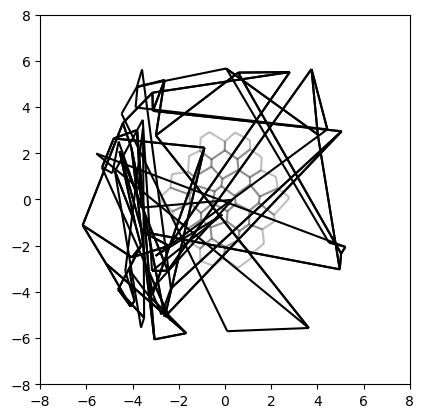

In [ ]:
mesh_new = deepcopy(mesh)


#mesh_new.transform_primal_vertices(dln.shear_mat(1.2)) # edge and vertex based give same result

#mesh_new.transform_primal_vertices(lambda x: x + 0.05*np.array([x[0], np.sign(x[1])*x[1]**2]))


for key, val in mesh_new.faces.items():
    val.primal_coords = voronoi_2d[face_key_dict[key]] + dr[face_key_dict[key]]

mesh.cellplot(alpha=.25)
mesh_new.cellplot(alpha=1)

lim = 8
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.gca().set_aspect("equal", adjustable="box")


In [ ]:
voronoi = np.array([mesh.faces[key].primal_coords for key in face_keys])
voronoi_plus_theta = np.array([mesh_new.faces[key].primal_coords for key in face_keys])

dr = voronoi_plus_theta-voronoi

KeyError: 64

In [ ]:
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# as reference, find the per-cell strain tensor

strain_dict = {}

for vkey in vertex_keys:
    if not mesh.vertices[vkey].is_bdry():
        pre = np.stack([fc.primal_coords for fc in mesh.vertices[vkey].faces])
        pst = np.stack([fc.primal_coords for fc in mesh_new.vertices[vkey].faces])
        M = np.linalg.lstsq(pre, pst, rcond=None)[0]
        #strain_dict[vkey] = (M+M.T)/2 - np.eye(2)
        strain_dict[vkey] = M

In [ ]:
strain_dict_edge_original = {} # reference 

for vkey in vertex_keys:
    if not mesh.vertices[vkey].is_bdry():
        pre = np.stack([fc.primal_coords for fc in mesh.vertices[vkey].faces])
        pst = np.stack([fc.primal_coords for fc in mesh_new.vertices[vkey].faces])
        # compute edges
        pre = pre - np.roll(pre, 1, axis=0)
        pst = pst - np.roll(pst, 1, axis=0)
        M = np.linalg.lstsq(pre, pst, rcond=None)[0]
        #strain_dict_edge[vkey] = (M+M.T)/2 - np.eye(2)
        strain_dict_edge_original[vkey] = M
        
# the strain on vertices and the strain on edges is different for non-affine transformations.

KeyError: 43

In [ ]:
cell_edges.shape

(6, 2)

In [ ]:
inds

array([[164,  51],
       [163, 164],
       [167, 163],
       [169, 167],
       [ 52, 169],
       [ 51,  52]])

In [ ]:
mean_edge_len = np.mean(list(mesh.get_primal_edge_lens().values()))

strain_dict_edge = {}
for vkey in vertex_keys:
    if not mesh.vertices[vkey].is_bdry():
        inds = cell_he_dict[vkey]
        dr_cell = dr[inds[:,0],:]-dr[inds[:,1],:]
        cell_edges = voronoi_2d[inds[:,0],:]-voronoi_2d[inds[:,1],:]
        
        strains = np.einsum('ai,aj->aij', cell_edges, dr_cell)
        # normalize ? yes. but can just do it based on mean edge length with lower error actually
        #edge_lengths = np.linalg.norm(cell_edges, axis=1)
        #strains = (strains.T / edge_lengths**2).T
        strains = strains / mean_edge_len**2
        
        strain_dict_edge[vkey] = np.eye(2) + 2*strains.mean(axis=0)  # heuristic 
        
        #pre = cell_edges
        #pst = cell_edges+dr_cell
        
        #M = np.linalg.lstsq(pre, pst, rcond=None)[0]
        #strain_dict_edge[vkey] = M #(M+M.T)/2 - np.eye(2) 
        #strain_dict_isogonal[vkey] = M 
        
        
        # try using this in combination with Voronoi position based shape metric.

In [ ]:
a = np.stack([strain_dict_edge_original[vkey] for vkey in vertex_keys if not mesh.vertices[vkey].is_bdry()])
b = np.stack([strain_dict_edge[vkey] for vkey in vertex_keys if not mesh.vertices[vkey].is_bdry()])


#np.corrcoef(a[:,0,0], b[:,0,0])[0,1], np.corrcoef(a[:,0,1], b[:,0,1])[0,1], np.corrcoef(a[:,1,1], b[:,1,1])[0,1]

# .8 diag, .55 off diag

In [ ]:
np.median(np.linalg.norm(a-b, axis=(1,2)) / np.linalg.norm(a, axis=(1,2))) # 7% error

0.02791822587012618

In [ ]:
np.mean(a[:,0,0]/b[:,0,0]), np.mean(a[:,1,1]/b[:,1,1])

(1.0007001634616541, 1.0102243005415652)

In [ ]:
vkey = 128

strain_dict_edge_original[vkey]

array([[ 0.862, -0.099],
       [-0.075,  1.111]])

In [ ]:
strain_dict_edge[vkey]

array([[ 0.848, -0.098],
       [-0.098,  1.124]])

In [ ]:
inds

array([[164,  51],
       [163, 164],
       [167, 163],
       [169, 167],
       [ 52, 169],
       [ 51,  52]])

In [ ]:
np.mean(a[:,0,0]/b[:,0,0]), np.mean(a[:,1,1]/b[:,1,1])

(0.33073870545420414, 0.438124950466752)

In [ ]:
vkey = 128

strain_dict[vkey]

array([[ 0.031, -0.103],
       [-0.103,  0.223]])

In [ ]:
strain_dict_edge[vkey]

array([[-0.038, -0.103],
       [-0.103,  0.26 ]])

In [ ]:
np.linalg.eigh(strain_dict_isogonal[vkey])

(array([-0.286, -0.006]),
 array([[-0.999,  0.044],
        [-0.044, -0.999]]))

In [ ]:
np.linalg.eigh(strain_dict[vkey])

array([[ 0.69548701, -0.03976715],
       [-0.03976715,  0.79739001]])

array([[ 0.5888853 , -0.0146834 ],
       [-0.0146834 , -0.14604115]])

array([[ 0.00738397, -1.31723658],
       [ 1.21358815,  0.01985652],
       [ 3.61824685,  2.84825743],
       [-1.35719882, -0.58062871],
       [-1.22003116,  1.26586508],
       [ 0.0858955 ,  2.13218689]])

In [ ]:
dr_cell = {key: dr[val[:,0],:]-dr[val[:,1],:] for key, val in cell_he_dict.items()}[53]
cell_edges = {key: voronoi_2d[val[:,0],:]-voronoi_2d[val[:,1],:] for key, val in cell_he_dict.items()}[53]

[vectors_angle(x, y) for x, y in zip(dr_cell, cell_edges)] # as expected parallel or anti-parallel

[3.141592653589793,
 0.0,
 3.141592638688632,
 3.141592653589793,
 1.4901161193847656e-08,
 1.4901161193847656e-08]

In [ ]:
# second, heuristic option: 

[Face(fid=58, primal_coords=[-0.8, 2.3], hes=[174, 175, 176]),
 Face(fid=182, primal_coords=[-1.6, 1.9], hes=[547, 548, 546]),
 Face(fid=181, primal_coords=[-1.9, 2.3], hes=[543, 544, 545]),
 Face(fid=188, primal_coords=[-1.9, 2.9], hes=[564, 565, 566]),
 Face(fid=268, primal_coords=[-1.5, 3.1], hes=[806, 804, 805]),
 Face(fid=269, primal_coords=[-1.0, 3.1], hes=[807, 808, 809])]

In [ ]:
def cot(x): return np.cos(x)/np.sin(x)

[<matplotlib.lines.Line2D>]

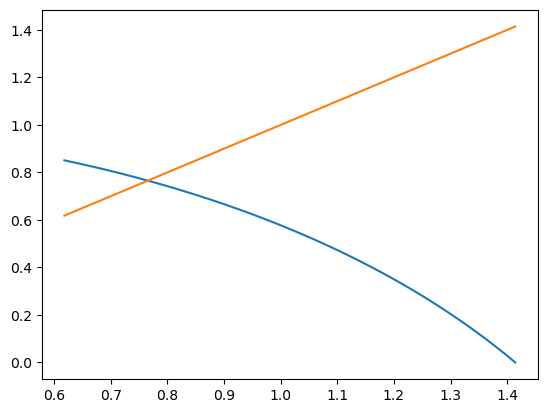

In [ ]:
x = np.linspace(0.2*np.pi, 0.5*np.pi, 100)

T = 2*np.sin(x/2)
l_v = T*cot(x)


plt.plot(T, l_v)
p = np.polyfit(x, l_v, deg=1)
#plt.plot(x, np.polyval(p, x), color="tab:blue", ls="--")

pT = np.polyfit(T, l_v, deg=1)

#plt.plot(T, np.polyval(pT, T))
#print(pT)

plt.plot(T, T)

In [ ]:
# find the aposite vertex - this works. this way, we can calculate the 2nd derivative

v = mesh.vertices[124]
adj = v.incident + [he.twin for he in v.incident]

[[he.twin.nxt.vertices[1]._vid for he in fc.hes if not he in adj] for fc in v.faces]

[[110], [134], [146], [137], [113], [98]]

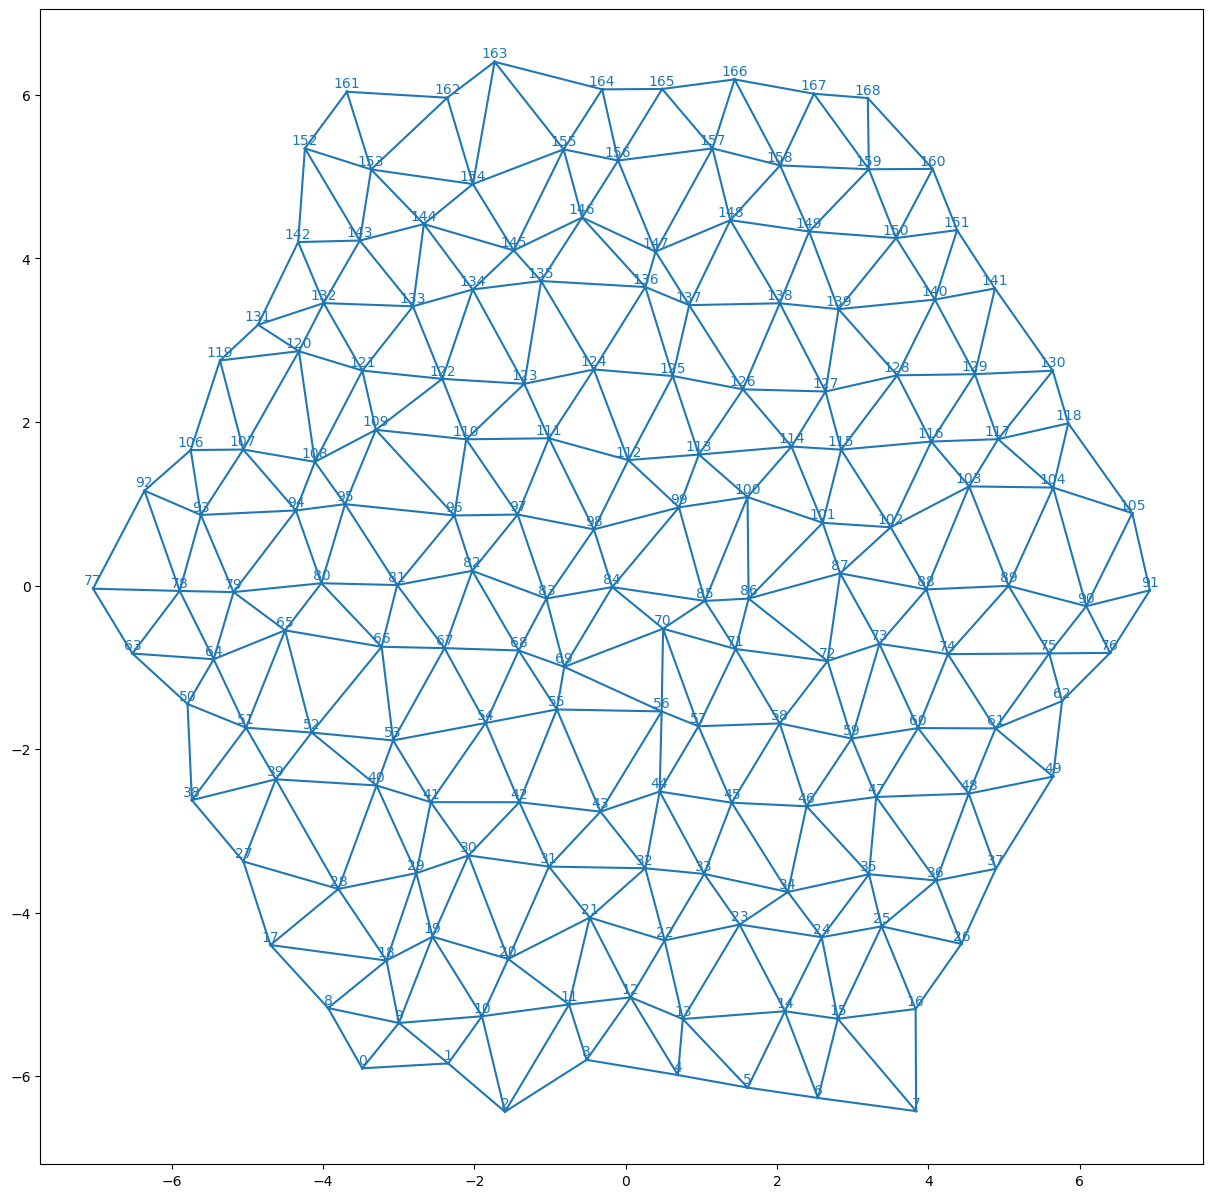

In [ ]:
fig = plt.figure(figsize=(15,15))
mesh.triplot()
mesh.labelplot(vertex_labels=True, face_labels=False, halfedge_labels=False)

In [ ]:
help(mesh.labelplot)

Help on method labelplot in module CE_simulation.mesh:

labelplot(vertex_labels=True, face_labels=True, halfedge_labels=False, cell_labels=False, ax=None) method of CE_simulation.isogonal.CellHalfEdgeMesh instance
    For debugging purposes, plot a trimesh with face/edge/vertex IDs attached

